# Cell Migration: Simulation Study with Calibrated Model

In [9]:
import os
import pickle
from pathlib import Path
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import numpy as np
import math
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from matplotlib.gridspec import GridSpec
from scipy.stats import circmean, circstd

from summary_stats import reduce_to_coordinates, compute_MSD_lags, turning_angle, angle_degree, velocity

In [3]:
gp = os.getcwd()

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
    'pulse_period': './Global/Constant[@symbol="puls_period"]',
}
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis (energy potential)
    'move.strength': 10.,  # strength of directed motion (energy potential)
    'move.duration.mean': 0.1,  # mean of exponential distribution (seconds)
    'cell_nodes_real': 50.,  # area of the cell  (\mu m^2)
    #'pulse_period': 30.,  # length of the pulsing chemokine (seconds)
}
obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
real_posterior = np.load(f'abc_results_real/posterior_samples_npe.npy')
real_posterior_median = np.median(real_posterior, axis=0)

models_simulations = {  # 1sec time steps
    'classic': 'cell_movement_v24_1sec.xml',
    'no_chemokine': 'cell_movement_v24-no-chemokine.xml',  # for simulation without chemokine
    'no_persistence': 'cell_movement_v24-no-persistent.xml',  # for simulation without persistent random walk
    'pulsing_chemokine_2': 'cell_movement_v24-puls_prefactor.xml',  # for simulation with pulsing chemokine, time in minutes
    'pulsing_chemokine_5': 'cell_movement_v24-puls_prefactor.xml',
    'pulsing_chemokine_10': 'cell_movement_v24-puls_prefactor.xml',
    'pulsing_chemokine_20': 'cell_movement_v24-puls_prefactor.xml',
    'pulsing_chemokine_30': 'cell_movement_v24-puls_prefactor.xml',
    'pulsing_chemokine_40': 'cell_movement_v24-puls_prefactor.xml',
    'pulsing_chemokine_50': 'cell_movement_v24-puls_prefactor.xml',
    'pulsing_chemokine_60': 'cell_movement_v24-puls_prefactor.xml',
}

# defining the summary statistics function
min_sequence_length = 0
cells_in_population = 50
# note: this is different for inference
max_sequence_length = 10000
def prepare_sumstats(output_morpheus_model) -> dict:
    sim_coordinates = reduce_to_coordinates(output_morpheus_model,
                                            minimal_length=min_sequence_length,
                                            maximal_length=max_sequence_length,
                                            cut_region_of_interest=False
                                            )

    # we now do exactly the same as in the BayesFlow workflow, but here we get only one sample at a time
    data_transformed = np.ones((cells_in_population, max_sequence_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    if len(sim_coordinates) != 0:
        # some cells were visible in the simulation
        for c_id, cell_sim in enumerate(sim_coordinates):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_transformed[c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_transformed[c_id, -len(cell_sim['y']):, 1] = cell_sim['y']
    
    return {'sim': data_transformed}

sumstat = SummaryStatistics(sum_stat_calculator=prepare_sumstats)
if os.path.exists('simulation_study_sims.pkl'):
    with open('simulation_study_sims.pkl', 'rb') as f:
        models_simulations = pickle.load(f)
else:
    @delayed
    def wrapper_fun(model_name):
        model_path = models_simulations[model_name]
        _par_map_temp = par_map.copy()
        if not model_name.startswith("pulsing_chemokine"):
            # remove the pulse period parameter
            _par_map_temp.pop('pulse_period')
        # define the model object
        model = morpheus_model.MorpheusModel(
            model_path, par_map=_par_map_temp, par_scale="log10",
            show_stdout=False, show_stderr=False,
            clean_simulation=True,
            raise_on_error=False, sumstat=sumstat
        )
        sim_dict = {key: p for key, p in zip(obs_pars.keys(), real_posterior_median)}
        if model_name.startswith("pulsing_chemokine"):
            # set the pulse period
            sim_dict['pulse_period'] = np.log10(float(model_name.split('_')[-1]) * 60)  # convert minutes to seconds
        posterior_sim = model(sim_dict)['sim']
        return {model_name: posterior_sim}

    models_simulations = Parallel(n_jobs=10, verbose=1)(wrapper_fun(model_name) for model_name in models_simulations.keys())
    # convert to dict
    models_simulations = {k: v for d in models_simulations for k, v in d.items()}
    # save the simulations
    with open('simulation_study_sims.pkl', 'wb') as f:
        pickle.dump(models_simulations, f)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  11 | elapsed:   20.5s remaining:   35.9s
[Parallel(n_jobs=10)]: Done  11 out of  11 | elapsed:   26.6s finished


In [15]:
from summary_stats import compute_summary_stats
import pyabc
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.mean': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}

test_id = 2
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})

np.random.seed(test_id)
test_params = np.array(list(prior.rvs().values()))
if not os.path.exists(os.path.join(gp, f'test_sim_{test_id}.npy')):
    raise FileNotFoundError('Test data not found')
else:
    test_sim = np.load(os.path.join(gp, f'test_sim_{test_id}.npy'))
    test_sim_full = {'sim_data': test_sim}
results_path = f'abc_results_{test_id}'
test_sim.shape

def make_sumstat_dict(data) -> dict:
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]
    data = data[0]  # only one full simulation
    assert data.ndim == 3
    # compute the summary statistics
    msd_list, ta_list, v_list, ad_list = compute_summary_stats(data)
    cleaned_dict = {
        'msd': np.array(msd_list).flatten(),
        'ta': np.array(ta_list).flatten(),
        'vel': np.array(v_list).flatten(),
        'ad': np.array(ad_list).flatten(),
    }
    return cleaned_dict

In [16]:
make_sumstat_dict(test_sim)

{'msd': array([   3.78245989,  475.65269914,   84.78735306,   99.79166849,
         538.34594698,  367.01576493,  388.03686944,  245.10674802,
         462.01241237,    0.        ,  746.25442125,  250.65324009,
           0.        , 1254.76502474,    3.38078273,  921.59299027,
        1350.57536231, 1233.93950092,    4.70297004, 1408.49451369,
          13.7239695 ,  185.72361431,    0.        , 1221.61486364,
         217.3487167 ,    4.1004543 ,    2.44353603, 1246.23728494,
        1222.88490912,  192.12302064,    0.        ,  363.68519185,
        1436.44046833, 1203.03166629, 1219.78156015,   45.858142  ,
        1144.40205295,   16.10055934, 1271.79196571, 1227.38069727,
         563.762257  ,    0.        ,    0.        ,    0.        ,
          62.27669576,    0.        ,  801.77538693,   28.73665322,
           3.76572334,   34.71160092]),
 'ta': array([-9.38261625e-03, -9.38261625e-03, -9.88054695e-03, -6.65591664e-03,
        -1.42707399e-02, -1.33118333e-02, -1.88173394e-

# Analysis with Real Data Calibrated Model

In [4]:
# # # Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'legend.frameon': False,
    #'figure.dpi': 300,
    #'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.transparent': False
})


# ────────────────────────────────
#  Core mathematical functions
# ────────────────────────────────

def msd_with_sem(trajs):
    """
    Calculate MSD with standard error of the mean.

    Parameters:
        trajs : array (n_cells, T, 2)

    Returns:
        msd_mean : array (T,) - mean MSD
        msd_sem : array (T,) - standard error of mean
        lags : array (T,) - lag times
    """
    n_cells, T = trajs.shape[:2]
    lags = np.arange(T)[1:]  # skip lag 0

    msd_individual = compute_MSD_lags(trajs)
    msd_mean = np.mean(msd_individual, axis=0)
    msd_sem = np.std(msd_individual, axis=0) / np.sqrt(n_cells)
    return msd_mean, msd_sem, lags


def fit_power_law(x, y, x_range=None):
    """
    Fit power law: y = A * x^α

    Returns:
        alpha : float - power law exponent
        A : float - prefactor
        r_squared : float - goodness of fit
    """
    if x_range is not None:
        mask = (x >= x_range[0]) & (x <= x_range[1])
        x_fit, y_fit = x[mask], y[mask]
    else:
        x_fit, y_fit = x, y

    # Remove zeros and invalid values
    valid = (x_fit > 0) & (y_fit > 0) & np.isfinite(x_fit) & np.isfinite(y_fit)
    x_fit, y_fit = x_fit[valid], y_fit[valid]

    if len(x_fit) < 2:
        return np.nan, np.nan, np.nan

    # Log-linear fit
    log_x, log_y = np.log10(x_fit), np.log10(y_fit)
    coeffs = np.polyfit(log_x, log_y, 1)
    alpha, log_A = coeffs[0], coeffs[1]
    A = 10**log_A

    # Calculate R²
    y_pred = A * x_fit**alpha
    ss_res = np.sum((y_fit - y_pred)**2)
    ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    return alpha, A, r_squared


def calculate_directional_stats(angles):
    """Calculate circular statistics for turning angles."""
    if len(angles) == 0:
        return {'mean': np.nan, 'std': np.nan, 'concentration': np.nan}

    mean_angle = circmean(angles)
    std_angle = circstd(angles)

    # Calculate concentration parameter (inverse of circular variance)
    R = np.abs(np.mean(np.exp(1j * angles)))
    concentration = R / (1 - R) if R < 1 else np.inf

    return {
        'mean': mean_angle,
        'std': std_angle,
        'concentration': concentration,
        'mean_resultant_length': R
    }


# ────────────────────────────────────────────────────────────────────
# main plotting routine
# ────────────────────────────────────────────────────────────────────
def plot_trajectory_overlay(
        ax, trajs, *, n_show=50, alpha=0.6, colormap='tab10',
        show_start_end=True, scale_bar=None, show_image=True,
        x_min=None, x_max=None, y_min=None, y_max=None,
        img_path='Cell_migration_grid_v3_final2_invers.tiff', plot_legend=True):
    """
    Overlay trajectories with start/end markers and a *cropped & scaled*
    background image that never alters the data limits.

    Parameters are identical to your earlier version.
    """
    # ─────────────── trajectories & markers ────────────────
    n_show = min(n_show, len(trajs))
    cmap   = plt.colormaps.get_cmap(colormap)
    colours = cmap(np.linspace(0, 1, n_show))

    for i, tr in enumerate(trajs[:n_show]):
        ax.plot(tr[:, 0], tr[:, 1],
                color=colours[i], lw=0.8, alpha=alpha, zorder=2)

        handles = []
        if show_start_end:
            h = ax.scatter(*tr[0],  c='black', alpha=0.7, s=15,  marker='o', lw=0.5, zorder=3, label='Start')
            handles.append(h)
            h = ax.scatter(*tr[-1], c='black', alpha=0.7, s=15, marker='s', lw=0.5, zorder=3, label='End of trajectory')
            handles.append(h)

    # ─────────────── background image (cropped) ────────────────
    if x_min is None:
        x_min, x_max = ax.get_xlim()
    if y_min is None:
        y_min, y_max = ax.get_ylim()
    if show_image and Path(img_path).exists():
        # read image so its aspect matches the data window
        img = plt.imread(img_path)
        ax.imshow(img,
                  origin='lower',
                  #extent=[x_min, x_max, y_min, y_max],
                  aspect='auto',          # preserve pixel squares
                  zorder=0,
                  interpolation=['bicubic', 'bessel', 'hermite', 'nearest', 'spline16', 'mitchell', 'bilinear', 'sinc', 'none', 'gaussian', 'blackman', 'spline36', 'hanning', 'kaiser', 'lanczos', 'antialiased', 'hamming', 'catrom', 'quadric'][14]) # keep grid sharp

    # apply limits so nothing moves
    #ax.set_xlim(x_min, x_max)
    #ax.set_ylim(y_min, y_max)

    # ─────────────── cosmetics ────────────────
    if len(handles) > 0 and plot_legend:
        ax.legend(handles=handles, loc='lower center', ncols=2, bbox_to_anchor=(0.5, -0.7))

    if scale_bar is not None:
        add_scale_bar(ax, scale_bar)   # your own helper

    ax.set_aspect('auto', adjustable='box')
    #ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')
    ax.grid(True, alpha=0.3, lw=0.5)


def plot_polar_rose(ax, angles, bins=36, show_arrow=False, color='steelblue'):
    """Enhanced polar histogram with statistical annotations."""
    if len(angles) == 0:
        ax.text(0.5, 0.5, 'No valid angles', transform=ax.transAxes,
                ha='center', va='center')
        return

    # Create histogram
    counts, bin_edges = np.histogram(angles, bins=bins, range=(-np.pi, np.pi))
    widths = np.diff(bin_edges)
    centers = bin_edges[:-1] + widths/2

    # Normalize counts to probability density
    density = counts / (np.sum(counts) * widths)

    # Plot bars
    ax.bar(centers, density, width=widths, bottom=0.0,
                  align='center', alpha=1, color=color, edgecolor='white', linewidth=0.5)

    # Calculate and display statistics
    if show_arrow:
        stats = calculate_directional_stats(angles)

        # Add mean direction arrow
        if not np.isnan(stats['mean']):
            max_density = np.max(density)
            if max_density > 0.3:
                ax.arrow(stats['mean'], 0, 0, max_density * 0.8,
                        head_width=0.1, head_length=max_density*0.1,
                        fc='red', ec='red', linewidth=2, alpha=0.8, zorder=5)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 0.5) #np.max(density) * 1.1)
    #ax.set_xlabel('Turning angle')
    ax.text(-0.55, 0.5, 'Probability density', transform=ax.transAxes,
                horizontalalignment='left',  # Align text to the left
                verticalalignment='center',  # Align text to the top
                rotation=90)

    # Add angle labels
    ax.set_thetagrids(np.arange(0, 360, 45),
                     labels=['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°'])


def plot_msd_analysis(ax, trajs, colour_by_regime=True, plot_legend=True):
    """
    MSD ± SEM on log–log axes, optional power-law fits, and (if
    colour_by_regime=True) the MSD line segments are coloured according
    to the local log-slope:
        • red   → sub-diffusive   (α < 0.8)
        • green → diffusive       (0.8 ≤ α ≤ 1.2)
        • blue  → super-diffusive (α > 1.2)
    """
    # ------------------------------------------------------------------
    # 1. ensemble MSD and SEM
    # ------------------------------------------------------------------
    msd_mean, msd_sem, lags = msd_with_sem(trajs)          # your helper
    tau           = lags[1:]                               # skip τ = 0
    msd_vals      = msd_mean[1:]
    msd_errors    = msd_sem[1:]

    # ------------------------------------------------------------------
    # 2. regime colouring (optional)
    # ------------------------------------------------------------------
    if colour_by_regime:
        # log-space derivatives
        log_tau = np.log10(tau)
        log_msd = np.log10(msd_vals)
        slopes  = np.gradient(log_msd, log_tau)

        # masks for each regime
        masks   = {
            'sub'  : slopes < 0.75,
            'diff' : (slopes >= 0.75) & (slopes <= 1.25),
            'super': slopes > 1.25
        }
        colours = {'sub': '#D55E00', 'diff': '#0072B2', 'super': '#009E73'}
        #labels  = {'sub':  r'Sub-diff.  (α<0.8)',
        #           'diff': r'Diffusive (0.8≤α≤1.2)',
        #           'super':r'Super-diff. (α>1.2)'}
        labels  = {'sub':  r'Sub-diff.',
                   'diff': r'Diffusive',
                   'super':r'Super-diff.'}
        # make sure all labels are shown
        for key, label in labels.items():
            if label is not None:
                ax.errorbar([], [], yerr=[], color=colours[key], lw=2, label=label)

        # plot separate line segments, one per regime
        for key, mask in masks.items():
            if not np.any(mask):
                continue
            # break into contiguous runs
            idx     = np.where(mask)[0]
            splits  = np.where(np.diff(idx) > 1)[0] + 1
            chunks  = np.split(idx, splits)

            for chunk in chunks:
                ax.errorbar(tau[chunk], msd_vals[chunk],
                            yerr=msd_errors[chunk],
                            color=colours[key],
                            marker='o', ms=3, alpha=0.8)

    else:
        # single-colour MSD
        ax.errorbar(tau, msd_vals, yerr=msd_errors,
                    color='navy', marker='o', ms=3, alpha=0.8, label='MSD ± SEM')

    # ------------------------------------------------------------------
    # 3. log–log axes & cosmetics
    # ------------------------------------------------------------------
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlabel('Lag time τ (time steps)')
    ax.set_ylabel('MSD(τ)  (μm²)')
    ax.grid(True, which='both', alpha=0.3)
    ax.set_ylim(1, 1e7)
    if plot_legend:
        ax.legend(loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.7))


def add_scale_bar(ax, length, units='μm', loc='lower right'):
    """Add a scale bar to the plot."""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if loc == 'lower right':
        x = xlim[1] - (xlim[1] - xlim[0]) * 0.15
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.1
    else:
        x = xlim[0] + (xlim[1] - xlim[0]) * 0.05
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.1

    ax.plot([x-length, x], [y, y], 'k-', linewidth=3)
    ax.text(x-length/2, y + (ylim[1]-ylim[0])*0.02, f'{length} {units}',
            ha='center', va='bottom', fontsize=8)


def plot_run_length_distribution(ax, trajs, angle_threshold=30):
    """
    Plot the survival distribution P(run length > ℓ) for trajectories.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to draw on.
    trajs : array-like, shape (n_cells, T, 2)
        Trajectories of individual cells.
    angle_threshold : float, default=30
        Maximum turning angle (in degrees) for steps to be considered within a 'run'.
    """
    threshold = np.deg2rad(angle_threshold)
    run_lengths = []

    for tr in trajs:
        # Compute turning angles between successive displacement vectors
        angs = turning_angle({'x': tr[:, 0], 'y': tr[:, 1]})
        mask = np.abs(angs) < threshold

        # Pad with zeros to find contiguous True segments
        padded = np.concatenate(([0], mask.astype(int), [0]))
        diff = np.diff(padded)
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        lengths = ends - starts
        run_lengths.extend(lengths)

    run_lengths = np.array(run_lengths)
    if run_lengths.size == 0:
        raise ValueError("No runs detected. Check `angle_threshold` or trajectory data.")

    # Compute survival curve: for each unique run length ℓ, P(run > ℓ)
    unique_lengths = np.unique(run_lengths)
    survival = np.array([np.sum(run_lengths > L) / run_lengths.size for L in unique_lengths])

    # Plot as a step function on log-log axes
    ax.step(unique_lengths, survival, where='post', linewidth=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Run length (steps)')
    ax.set_ylabel('P(run length > ℓ)')
    ax.grid(True, which='both', alpha=0.3)
    ax.set_ylim(0.0001, 1)


def plot_velocity(ax, traj, dt=1.0, pulse_interval=30.0, show_pulse=True,
                  line_kwargs=None, pulse_kwargs=None):
    """
    Plot instantaneous speed and mark pulse onsets every `pulse_interval` seconds.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on.
    traj : array-like, shape (T, 2)
        Single trajectory (x, y) over time.
    dt : float, default=30.0
        Time per frame (s).
    pulse_interval : float, default=30.0
        Seconds between pulse events.
    show_pulse : bool, default=True
        Whether to show pulse markers.
    line_kwargs : dict, optional
        Additional kwargs passed to ax.plot for the speed trace.
    pulse_kwargs : dict, optional
        Additional kwargs passed to ax.axvline and ax.scatter for pulse markers.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    # Compute speed and time axis
    speeds = velocity({'x': traj[:, 0], 'y': traj[:, 1]}, dt=dt)
    times = np.arange(len(speeds)) * dt

    # Default styling
    if line_kwargs is None:
        line_kwargs = {'color': 'C0', 'linewidth': 1.5, 'label': 'Speed'}
    if pulse_kwargs is None:
        pulse_kwargs = {'color': 'C1', 'linestyle': '--', 'alpha': 0.7}

    # Plot speed trace
    ax.plot(times, speeds, **line_kwargs)

    # Determine pulse event times and indices
    max_time = times[-1]
    pulse_times = np.arange(0, max_time + pulse_interval, pulse_interval)
    pulse_indices = (pulse_times / dt).astype(int)
    pulse_indices = pulse_indices[pulse_indices < len(speeds)]

    # Mark pulses: vertical lines and point markers
    if show_pulse:
        for pt in pulse_times:
            if pt <= max_time:
                ax.axvline(pt, **pulse_kwargs)

        # Scatter at exact pulse points
        ax.scatter(times[pulse_indices], speeds[pulse_indices],
                   **{**pulse_kwargs, **{'marker': 'o', 's': 30, 'label': 'Pulse onset'}})

    # Labels & grid
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Speed (μm/min)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    ax.set_ylim(0, 700)
    return ax



def sequence_enters_circle(center, radius, points):
    x0, y0 = center
    return any(
        math.hypot(x - x0, y - y0) <= radius
        for x, y in points
    )


def count_sequences_entering(center, radius, sequences):
    return sum(
        1 for seq in sequences
        if sequence_enters_circle(center, radius, seq)
    )



# ────────────────────────────────
#  Master plotting function
# ────────────────────────────────
def create_publication_figure(trajs,
                             save_path='cell_motion_analysis.pdf',
                             figure_size=(10, 1.5),
                             n_trajectories=50,
                             rose_bins=36,
                             scale_bar_length=None,
                             show_image=True,
                             plot_legend=False,
                             show_pulse=False):
    """
    Create publication-quality figure with enhanced visualizations.

    Parameters:
        trajs : array (n_cells, T, 2) - trajectory data
        save_path : str - output file path
        figure_size : tuple - figure dimensions in inches
        n_trajectories : int - number of trajectories to show in overlay
        rose_bins : int - number of bins for polar histogram
        scale_bar_length : float - length of scale bar in micrometers
        show_image : bool - whether to show background image
        plot_legend : bool - whether to plot legend
        show_pulse : bool - whether to show pulse markers in velocity plot
    """
    # Calculate turning angles for all trajectories
    all_angles = []
    for traj in trajs:
        angles = turning_angle({'x': traj[:, 0], 'y': traj[:, 1]})
        if len(angles) > 0:
            all_angles.extend(angles)
    all_angles = np.array(all_angles)

    # Create figure with custom layout
    fig = plt.figure(figsize=figure_size)
    gs = GridSpec(1, 3, figure=fig, width_ratios=[0.33, 0.33, 0.33], wspace=0.25)

    # Panel A: Trajectory overlay
    ax1 = fig.add_subplot(gs[0, 0])
    x_min, x_max = 500, 650
    y_min, y_max = 600, 2100
    plot_trajectory_overlay(ax1, trajs, n_show=n_trajectories,
                            x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
                           scale_bar=scale_bar_length, show_image=show_image, plot_legend=plot_legend)

    # Panel B: Turning angle distribution
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    plot_polar_rose(ax2, all_angles, bins=rose_bins)

    # Panel C: MSD analysis or Run-length distribution panel or velocity distribution
    ax3 = fig.add_subplot(gs[0, 2])
    plot_msd_analysis(ax3, trajs, plot_legend=plot_legend)
    #plot_run_length_distribution(ax3, trajs, angle_threshold=30)
    #plot_velocity(ax3, trajs, show_pulse=show_pulse)

    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    center = (1172.5/2, (1500+1500/2+270)/1.31)
    radius = 550
    count = count_sequences_entering(center, radius, trajs)
    #theta = np.linspace(0, 2 * np.pi, 400)
    #x = center[0] + radius * np.cos(theta)
    #y = center[1] + radius * np.sin(theta)
    #ax1.plot(x, y)

    if len(all_angles) > 0:
        # Print summary statistics
        print(f"\n=== Analysis Summary ===")
        stats = calculate_directional_stats(all_angles)
        print(f"Mean turning angle: {np.degrees(stats['mean']):.1f}°")
        print(f"Turning angle std: {np.degrees(stats['std']):.1f}°")
        print(f"Directional persistence (R): {stats['mean_resultant_length']:.3f}")
        print(f"Cells in square: {count} / {trajs.shape[0]} ({count/trajs.shape[0]*100:.1f}%)")
    return fig, count

classic

=== Analysis Summary ===
Mean turning angle: 1.6°
Turning angle std: 64.8°
Directional persistence (R): 0.528
Cells in square: 22 / 50 (44.0%)


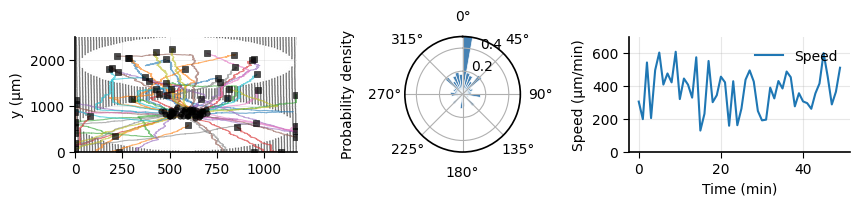

no_chemokine

=== Analysis Summary ===
Mean turning angle: 0.2°
Turning angle std: 54.3°
Directional persistence (R): 0.639
Cells in square: 7 / 50 (14.0%)


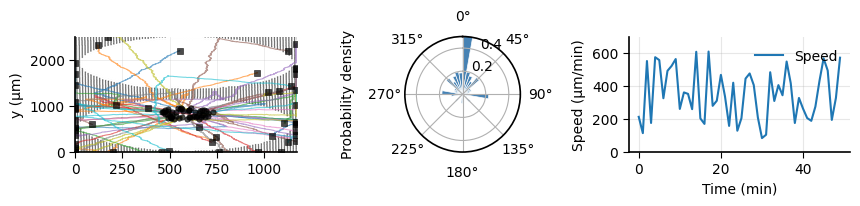

no_persistence

=== Analysis Summary ===
Mean turning angle: 3.6°
Turning angle std: 78.7°
Directional persistence (R): 0.389
Cells in square: 41 / 50 (82.0%)


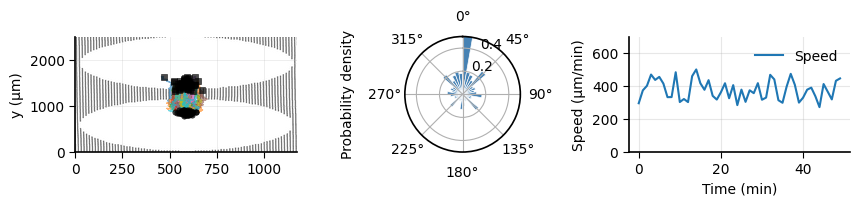

pulsing_chemokine_2

=== Analysis Summary ===
Mean turning angle: 0.5°
Turning angle std: 56.5°
Directional persistence (R): 0.615
Cells in square: 12 / 50 (24.0%)


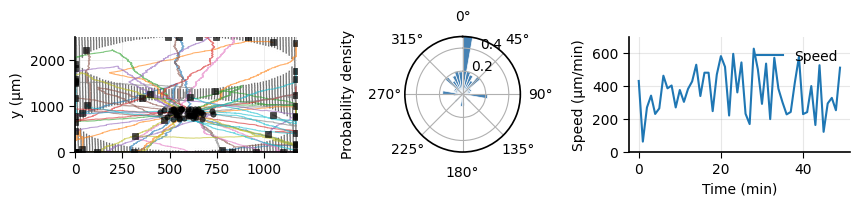

pulsing_chemokine_5

=== Analysis Summary ===
Mean turning angle: 0.4°
Turning angle std: 56.6°
Directional persistence (R): 0.613
Cells in square: 11 / 50 (22.0%)


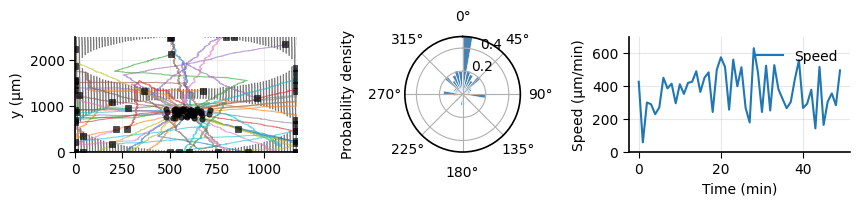

pulsing_chemokine_10

=== Analysis Summary ===
Mean turning angle: 0.3°
Turning angle std: 56.0°
Directional persistence (R): 0.620
Cells in square: 11 / 50 (22.0%)


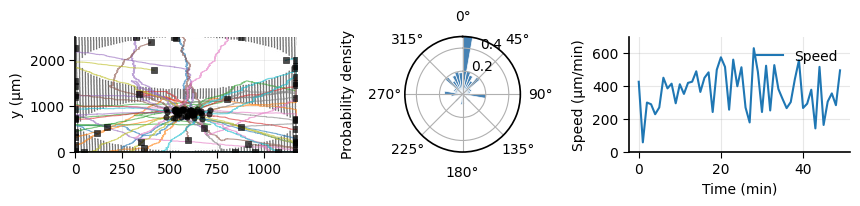

pulsing_chemokine_20

=== Analysis Summary ===
Mean turning angle: 0.6°
Turning angle std: 59.4°
Directional persistence (R): 0.585
Cells in square: 17 / 50 (34.0%)


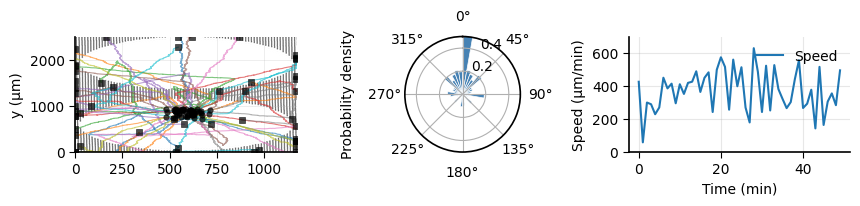

pulsing_chemokine_30

=== Analysis Summary ===
Mean turning angle: 0.8°
Turning angle std: 60.3°
Directional persistence (R): 0.575
Cells in square: 18 / 50 (36.0%)


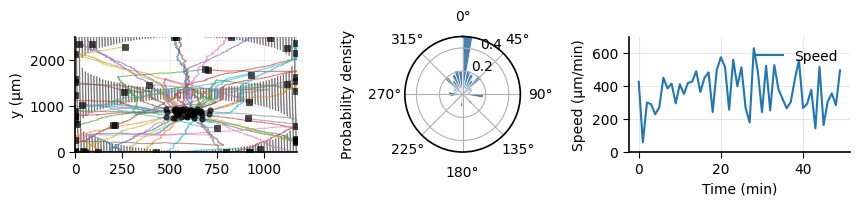

pulsing_chemokine_40

=== Analysis Summary ===
Mean turning angle: 1.2°
Turning angle std: 62.2°
Directional persistence (R): 0.554
Cells in square: 22 / 50 (44.0%)


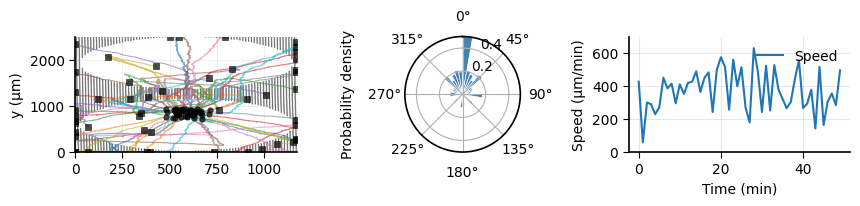

pulsing_chemokine_50

=== Analysis Summary ===
Mean turning angle: 1.4°
Turning angle std: 64.4°
Directional persistence (R): 0.532
Cells in square: 23 / 50 (46.0%)


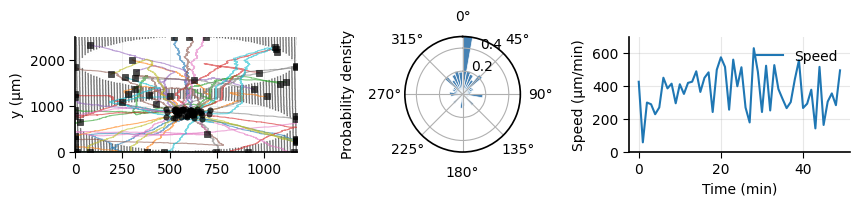

pulsing_chemokine_60

=== Analysis Summary ===
Mean turning angle: 1.5°
Turning angle std: 65.6°
Directional persistence (R): 0.519
Cells in square: 22 / 50 (44.0%)


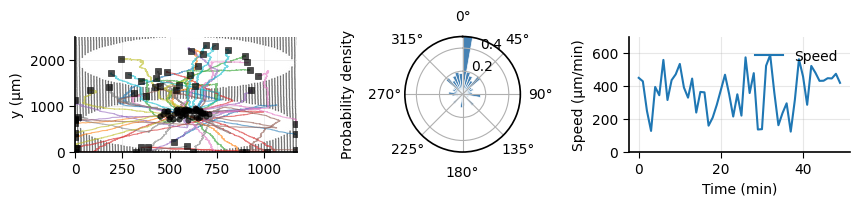

In [5]:
start_time = 180  # 3min - 1hour
counts_end_trajs = []
for model_name, sim_data in models_simulations.items():
    print(model_name)
    fig, c = create_publication_figure(
        sim_data[:, 180:3600],
        save_path=f'plots/simulation_study_{model_name}.svg',
        n_trajectories=50,
        show_image=True,
        #plot_legend=True if model_name == 'classic' else False
        #show_pulse=True if model_name == 'pulsing_chemokine' else False
    )
    plt.show()
    counts_end_trajs.append(c)

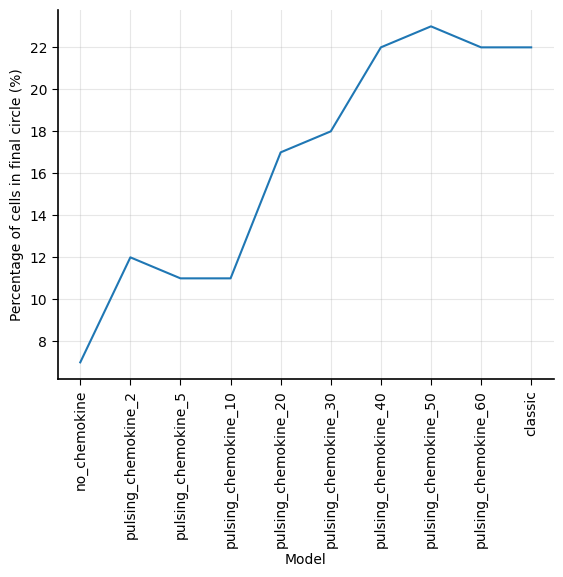

In [7]:
plot_index = [1,3,4,5,6,7,8,9,10,0]
plt.plot(np.array(list(models_simulations.keys()))[plot_index], np.array(counts_end_trajs)[plot_index])
plt.xticks(rotation=90)
plt.ylabel('Percentage of cells in final circle (%)')
plt.xlabel('Model')
plt.grid(True, alpha=0.3)
plt.show()